# Reducing the energy spread in our X-band linac

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



## Load the lattice from appropriate scripts

In [3]:
addpath('scripts/')

## Let's define some key parameters
We use a structure to collect all relevant parameters

In [4]:
%% Structure "setup"
setup.Q = -1; % single-particle charge, in units of e
setup.mass = RF_Track.electronmass; % MeV/c^2
setup.population = RF_Track.nC; % 50 * RF_Track.pC; % number of real particles per bunch

setup.sigma_t = 0.100; % mm/c
setup.sigma_pt = 0.1; % permille, momentum spread

setup.P_i = 100; % initial momentum, MeV/c
setup.P_f = 500; % final momentum, MeV/c

setup.phid = 0; % deg, phase of the RF structures
setup.mu = 90; % deg, FODO phase advance per cell

## Let's build the linac lattice
We use a standard FODO lattice, with four structures every two consecutive quadrupoles and 90 degrees phase advance per cell

In [5]:
LINAC = init_linac_lattice (setup);

P_i = 100
P_f = 500
n_FODO = 4


In [6]:
LINAC.size()

ans = 5


In [7]:
LINAC.get_length()

ans = 7.6327


## Let's define and track the reference particle and a bunch

In [8]:
P0 = init_reference_particle (setup);
B0 = init_bunch(setup);

% Track the reference particle
P1 = LINAC.track(P0);

In [9]:
P1.get_phase_space()

ans =

            0            0            0            0   7.6327e+03   4.7732e+02



## Perform tracking

In [10]:
B1 = LINAC.track(B0);

Let's make some plots...

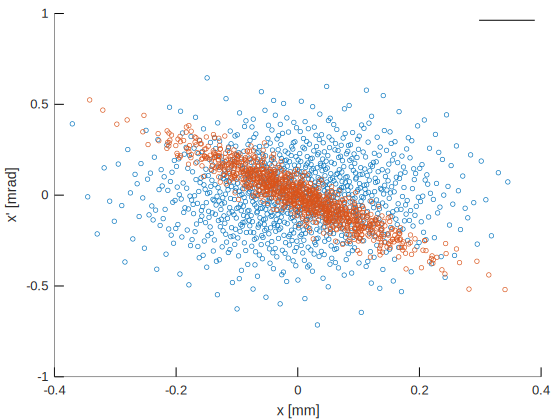

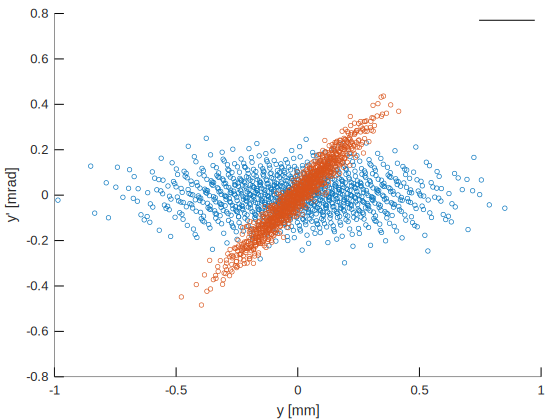

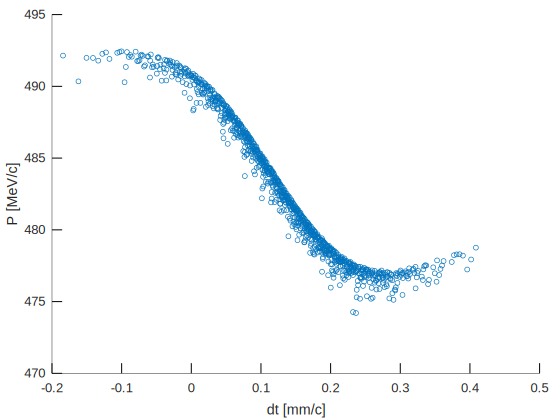

In [11]:
M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P');
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P');

figure
hold on
scatter(M0(:,1), M0(:,2))
scatter(M1(:,1), M1(:,2))
legend({'initial', 'final'});
xlabel('x [mm]');
ylabel('x'' [mrad]');

figure
hold on
scatter(M0(:,3), M0(:,4))
scatter(M1(:,3), M1(:,4))
legend({'initial', 'final'});
xlabel('y [mm]');
ylabel('y'' [mrad]');

figure
scatter(M1(:,5), M1(:,6))
xlabel('dt [mm/c]');
ylabel('P [MeV/c]');

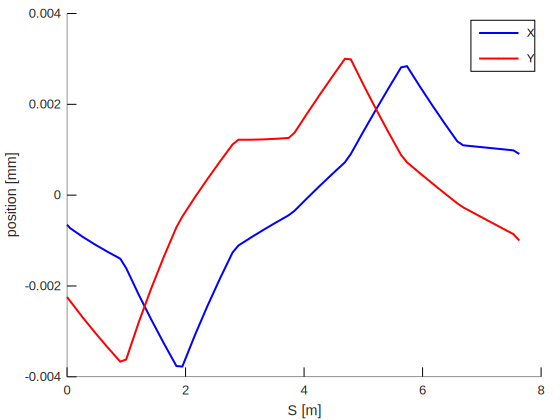

In [12]:
T = LINAC.get_transport_table('%S %mean_x %mean_y');

hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend('X', 'Y');
xlabel('S [m]');
ylabel('position [mm]');

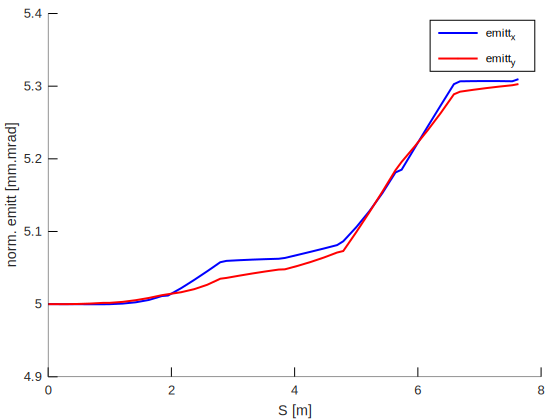

In [13]:
T = LINAC.get_transport_table('%S %emitt_x %emitt_y');

hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend('emitt_x', 'emitt_y');
xlabel('S [m]');
ylabel('norm. emitt [mm.mrad]');

## Let's reduce the energy spread

Let's perform a 1D optimisation of the phase to reduce the energy spread

In [14]:
function M = momentum_spread (LINAC, B0, phid)
    RF_Track;
    
    % set the phase of all structures
    for rf = LINAC.get_rf_elements()
        rf{1}.set_phid(phid);
    end
    
    % perform tracking
    B1 = LINAC.track(B0);
    I1 = B1.get_info();
    
    % return the normalized energy spread
    M = I1.sigma_pt;

    % M1 = B1.get_phase_space();
    % M = std(M1(:,6));
    
    % display some numbers...
    disp([ phid M ]);
end

merit = @(PHID) momentum_spread(LINAC, B0, PHID);

phid_min = fminbnd ( @(PHID) merit(PHID), -30, 30)

  -7.0820   7.8563
    7.0820   12.5036
  -15.8359    5.3869
  -21.2461    4.1780
  -24.5898    3.6862
  -26.6563    3.5332
  -28.3632    3.5123
  -27.8842    3.5081
  -27.8664    3.5080
  -27.8688    3.5080
  -27.8688    3.5080
  -27.8688    3.5080
phid_min = -27.869


Update the linac lattice to use the new phase

In [15]:
momentum_spread (LINAC, B0, 0.0)

         0   10.0930
ans = 10.093


In [16]:
setup.phid = phid_min;

LINAC_1 = init_linac_lattice(setup); % recreate the linac

P_i = 100
P_f = 500
n_FODO = 5


In [17]:
B1_corrected = LINAC_1.track(B0);

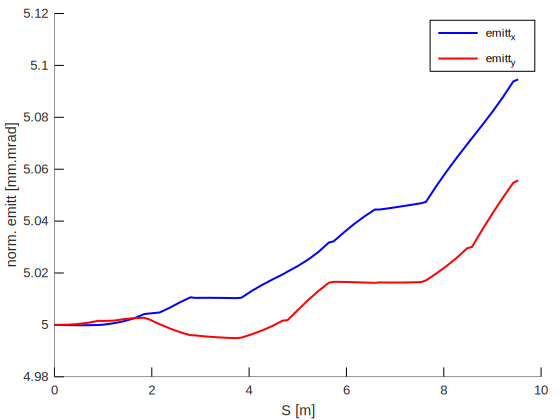

In [18]:
T = LINAC_1.get_transport_table('%S %emitt_x %emitt_y');

hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend('emitt_x', 'emitt_y');
xlabel('S [m]');
ylabel('norm. emitt [mm.mrad]');

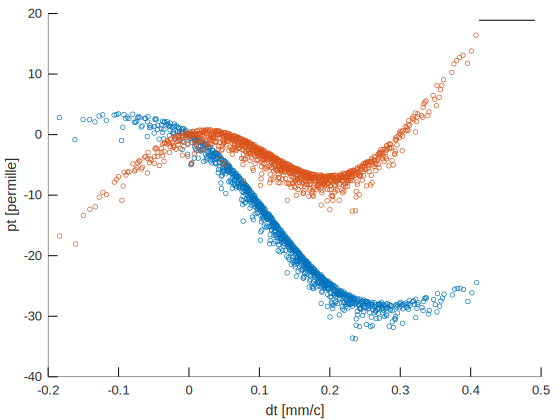

In [19]:
M1_uncorrected = B1.get_phase_space ('%x %xp %y %yp %dt %pt');
M1_corrected = B1_corrected.get_phase_space ('%x %xp %y %yp %dt %pt');

figure
hold on
scatter(M1_uncorrected(:,5), M1_uncorrected(:,6))
scatter(M1_corrected(:,5), M1_corrected(:,6))
legend({'uncorrected', 'corrected'});
xlabel('dt [mm/c]');
ylabel('pt [permille]');